In [1]:
import sys
import os

import json
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import Resize
import torch.nn.functional as F

from datasets import Dataset, Features, Value
from datasets import Image as HFImage
from transformers import AutoImageProcessor, AutoModel

ModuleNotFoundError: No module named 'datasets'

#### to import local funtions

ATENTION: You may have to change the path so that this can run on your device

In [2]:
# Checks on which folder the notebook is initially running
os.getcwd()

'/Users/mar-sangineto/Documents/sorbonne/cours/deepL/projet/OADino'

In [3]:
# Change according to where are you running so that the final path contains oadino

PROJECT_FOLDER_PATH = os.getcwd() # initial path + relative path to OADino
PROJECT_FOLDER_PATH

'/Users/mar-sangineto/Documents/sorbonne/cours/deepL/projet/OADino'

In [4]:
sys.path.append(PROJECT_FOLDER_PATH)

Internal imports

In [5]:
# from oadino.models import OADinoModel, OADinoPreProcessor, ConvVAE16
from oadino.models import OADinoModel, OADinoPreProcessor, ConvVAE16
from oadino.training import get_preprocessed_data, vae_loss

#### Settup device

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: cpu


### Dataset loading

In [7]:
# # loading CLEVR dataset avaliable on https://cs.stanford.edu/people/jcjohns/clevr/


# # loading CLEVRtex dataset avaliable on https://www.robots.ox.ac.uk/~vgg/data/clevrtex/#downloads

# # loading Stanford dataset avaliable on https://huggingface.co/datasets/tanganke/stanford_cars
# # Load the dataset in a tabular format with image URLs and metadata
# cars_dataset = load_dataset("tanganke/stanford_cars")

# # Access the training set directly
# cars_train_set = dataset["train"]

In [8]:
#from training_loop_initial_testing import create_hf_dataset

def create_hf_dataset(image_dir, maxsize=-1):
    image_paths = sorted(Path(image_dir).glob("*.png"))

    # Create dataset dict
    data_dict = {
        "image": [str(p) for p in image_paths[:maxsize]],
        "filename": [p.name for p in image_paths[:maxsize]],
    }

    dataset = Dataset.from_dict(
        data_dict,
        features=Features(
            {
                "image": HFImage(),
                "filename": Value("string"),
            }
        ),
    )

    return dataset

def transform_batch(batch):
    batch["image"] = [transform(img.convert("RGB")) for img in batch["image"]]
    return batch



In [9]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

CLEVR

In [10]:
DATA_PATH = "../data/"

train_data_path = Path(DATA_PATH + "/CLEVR_v1.0/images/train")
test_data_path = Path(DATA_PATH + "/CLEVR_v1.0/images/test")

train_dataset = create_hf_dataset(train_data_path, maxsize=4096)
test_dataset = create_hf_dataset(test_data_path, maxsize=4096)

train_dataset = train_dataset.with_transform(transform_batch)
train_dataset_name = "CLEVR_train_4K_224"
test_dataset_name  = f"{train_dataset_name}_test"
test_dataset = test_dataset.with_transform(transform_batch)


In [11]:
Path(DATA_PATH + "/CLEVR_v1.0/images/train").exists()

True

In [12]:
Path(test_data_path).exists()

True

In [13]:
train_pngs = sorted(train_data_path.glob("*.png"))
test_pngs  = sorted(test_data_path.glob("*.png"))

print("#train png:", len(train_pngs), "first:", train_pngs[0] if train_pngs else None)
print("#test  png:", len(test_pngs),  "first:", test_pngs[0] if test_pngs else None)

#train png: 70000 first: ../data/CLEVR_v1.0/images/train/CLEVR_train_000000.png
#test  png: 15000 first: ../data/CLEVR_v1.0/images/test/CLEVR_test_000000.png


In [14]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Data visualization

## Models

In [15]:
## Loading Backbone Models
hf_cache = Path("../data/")

dino_processor = AutoImageProcessor.from_pretrained(
    "facebook/dinov2-small", cache_dir=hf_cache
)
dino_model = AutoModel.from_pretrained("facebook/dinov2-base", cache_dir=hf_cache).to(device)

The image processor of type `BitImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 
Loading weights: 100%|██████████| 223/223 [00:00<00:00, 1634.06it/s, Materializing param=layernorm.weight]                                 


In [16]:
pre_processor = OADinoPreProcessor(dino_processor, dino_model)
vae = ConvVAE16()
model = OADinoModel(vae)

## Preprocessing OADino

visualizing the segmentations and patches

In [17]:
model_folder = pre_processor.backbone.config.name_or_path.replace("/", "_")
savedir = Path(hf_cache) / test_dataset_name / model_folder
print("Expected preprocess folder:", savedir)
print("Contains:", list(savedir.glob("*"))[:10])


Expected preprocess folder: ../data/CLEVR_train_4K_224_test/facebook_dinov2-base
Contains: []


In [ ]:
import shutil

model_folder = pre_processor.backbone.config.name_or_path.replace("/", "_")

train_savedir = Path(hf_cache) / train_dataset_name / model_folder
test_savedir  = Path(hf_cache) / f"{train_dataset_name}_test" / model_folder

def delete_if_empty(savedir):
    meta = savedir / "metadata.json"
    if meta.exists():
        m = json.loads(meta.read_text())
        print(savedir, "actual_samples:", m.get("actual_samples"))
        if m.get("actual_samples", 0) == 0:
            print("Deleting bad cache:", savedir)
            shutil.rmtree(savedir)

delete_if_empty(train_savedir)
delete_if_empty(test_savedir)


In [ ]:
debug_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
batch = next(iter(debug_loader))

with torch.no_grad():
    feats, patches, masks = pre_processor.get_global_features_and_patches(batch["image"], pca_q=None, pca_niter=2)

print("feats:", feats.shape)
print("patches:", patches.shape)
print("masks:", masks.shape, masks.dtype)
print("foreground per image:", masks.sum(dim=1))


feats: torch.Size([4, 768])
patches: torch.Size([4, 256, 3, 14, 14])
masks: torch.Size([4, 256]) torch.bool
foreground per image: tensor([113, 132, 148, 119])


In [21]:
preprocessed_train_dataset = get_preprocessed_data(
    dataset = train_dataset,
    dataset_name = train_dataset_name,
    image_size=224,
    preprocessor=pre_processor,
    base_dir=hf_cache,
    batch_size=64
)

Found directory ../data/CLEVR_train_4K_224/facebook_dinov2-base but could not load dataset
Metadata file not found at ../data/CLEVR_train_4K_224/facebook_dinov2-base/metadata.json. Make sure the dataset was finalized properly.
Data will be reprocessed
Processing 4096 samples...
Saving to: ../data/CLEVR_train_4K_224/facebook_dinov2-base


Batches: 100%|██████████| 64/64 [15:27<00:00, 14.49s/it]

Finalizing dataset...
Dataset saved to ../data/CLEVR_train_4K_224/facebook_dinov2-base
Total samples processed: 4096


In [22]:
preprocessed_test_dataset = get_preprocessed_data(
    dataset=test_dataset,
    dataset_name=test_dataset_name,
    image_size=224,
    preprocessor=pre_processor,
    base_dir=hf_cache,
    batch_size=64
)

Processing 4096 samples...
Saving to: ../data/CLEVR_train_4K_224_test/facebook_dinov2-base


Batches: 100%|██████████| 64/64 [16:35<00:00, 15.56s/it]

Finalizing dataset...
Dataset saved to ../data/CLEVR_train_4K_224_test/facebook_dinov2-base
Total samples processed: 4096


In [23]:
print("len(preprocessed_train_dataset):", len(preprocessed_train_dataset))
print("len(preprocessed_test_dataset):", len(preprocessed_test_dataset))

len(preprocessed_train_dataset): 4096
len(preprocessed_test_dataset): 4096


In [24]:
test_loader = DataLoader(preprocessed_test_dataset, batch_size=64, shuffle=False, num_workers=0)

### From the training...

#### Training configutations

In [25]:
config_path = PROJECT_FOLDER_PATH + "/runs/CLEVR_train_4K_224_20260202_210355/config.json"
with open(config_path, "r") as f:
    config = json.load(f)
    
for configuration in config:
    print(configuration, "=", config[configuration])

dataset_name = CLEVR_train_4K_224
model_name = OADinoModel
num_epochs = 10
learning_rate = 0.001
train_batch_size = 64
test_batch_size = 64
loss_beta = 0.0001
image_size = 224
device = cpu


### loading model

visualizing the final trained VAE

In [26]:
checkpoints_dir = "./runs/CLEVR_train_4K_224_20260202_210355/checkpoints/"
checkpoints_dir = Path(checkpoints_dir)
best_checkpoint_path = checkpoints_dir / "best_model.pt"
final_checkpoint_path = checkpoints_dir / "final_model.pt"

In [27]:
best_checkpoint = torch.load(best_checkpoint_path, map_location=device)
final_checkpoint = torch.load(final_checkpoint_path, map_location=device)

best_model = OADinoModel(ConvVAE16()).to(device)
final_model = OADinoModel(ConvVAE16()).to(device)


best_model.load_state_dict(best_checkpoint["model_state_dict"])
final_model.load_state_dict(final_checkpoint["model_state_dict"])

<All keys matched successfully>

In [28]:
final_model.eval()

OADinoModel(
  (vae): ConvVAE16(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (mean_layer): Sequential(
      (0): Linear(in_features=1024, out_features=32, bias=True)
    )
    (logvar_layer): Sequential(
      (0): Linear(in_features=1024, out_features=32, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=32, out_features=1024, bias=True)
      (1): ReLU(inplace=True)
     

# eval

In [29]:
@torch.no_grad()
def evaluate_model(model, loader, device, loss_beta=1e-4):
    model.eval()
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    n_batches = 0

    vae_in = model.vae.input_size
    resize_transform = Resize((vae_in, vae_in))

    for batch in loader:
        patches = batch["patches"].to(device)             # (B, P, 3, ps, ps)
        masks   = batch["masks"].to(device).bool()        # (B, P)
        flat_patches = resize_transform(patches.flatten(0, 1))  # (B*P, 3, vae_in, vae_in)
        flat_masks   = masks.flatten()                         # (B*P,)

        # Forward: only masked patches go through VAE
        x_hat, mean, logvar = model.encode_decode_object_patches(flat_patches, flat_masks)

        # Loss is computed against the masked originals
        loss, recon, kl = vae_loss(
            flat_patches[flat_masks],
            x_hat, mean, logvar,
            loss_beta,
            return_components=True,
        )

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()
        n_batches += 1

    return {
        "loss": total_loss / n_batches,
        "recon": total_recon / n_batches,
        "kl": total_kl / n_batches,
    }

loss_beta = config.get("loss_beta", 1e-4)  # from loaded config.json
best_metrics  = evaluate_model(best_model,  test_loader, device, loss_beta=loss_beta)
final_metrics = evaluate_model(final_model, test_loader, device, loss_beta=loss_beta)

print("BEST :", best_metrics)
print("FINAL:", final_metrics)


BEST : {'loss': 3.9315133206546307, 'recon': 3.9315128438174725, 'kl': 0.003606314021453727}
FINAL: {'loss': 3.931513302028179, 'recon': 3.931512825191021, 'kl': 0.003606314021453727}


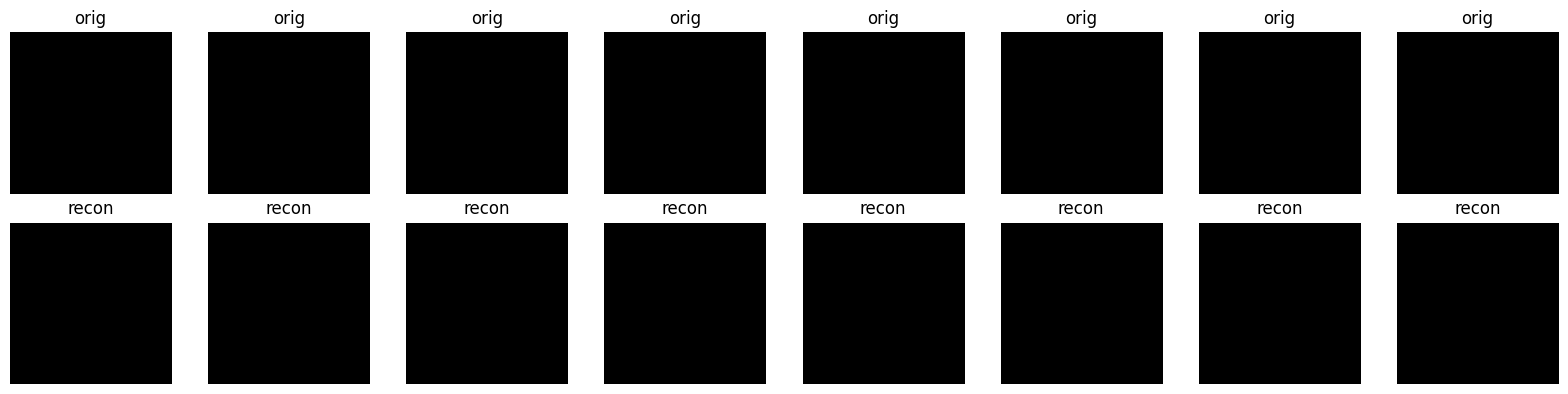

In [30]:
@torch.no_grad()
def show_reconstructions(model, dataset, device, n_show=8, seed=0):
    model.eval()
    g = torch.Generator().manual_seed(seed)

    idx = torch.randint(0, len(dataset), (1,), generator=g).item()
    sample = dataset[idx]
    patches = sample["patches"].to(device)      # (P, 3, ps, ps)
    masks   = sample["masks"].to(device).bool() # (P,)

    # pick some foreground patches
    fg_idx = torch.where(masks)[0]
    if len(fg_idx) == 0:
        print("No foreground patches in this sample.")
        return

    fg_idx = fg_idx[:n_show]
    x = patches[fg_idx]  # (n_show, 3, ps, ps)

    # run through model (expects flat inputs)
    vae_in = model.vae.input_size
    resize_transform = Resize((vae_in, vae_in))
    x_in = resize_transform(x)

    x_hat, _, _ = model.vae(x_in)

    # plot
    n = x.shape[0]
    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))
    for i in range(n):
        axes[0, i].imshow(x[i].permute(1,2,0).detach().cpu().clamp(0,1))
        axes[0, i].axis("off")
        axes[0, i].set_title("orig")

        axes[1, i].imshow(x_hat[i].permute(1,2,0).detach().cpu().clamp(0,1))
        axes[1, i].axis("off")
        axes[1, i].set_title("recon")
    plt.tight_layout()
    plt.show()

show_reconstructions(best_model, preprocessed_test_dataset, device, n_show=8, seed=0)


In [31]:
@torch.no_grad()
def compute_oadino_features(model, loader, device):
    """
    Returns:
      per_image_feats: list[Tensor] length N, each Tensor is (n_fg_patches, dim)
      pooled_feats: Tensor (N, dim) L2-normalized mean pooling (for fast coarse search)
    """
    model.eval()
    per_image = []
    pooled = []

    for batch in loader:
        global_feats = batch["features"].to(device)        # (B, ng)
        patches      = batch["patches"].to(device)         # (B, P, 3, ps, ps)
        masks        = batch["masks"].to(device).bool()    # (B, P)

        flat_patches = patches.flatten(0, 1)               # (B*P, 3, ps, ps)
        flat_masks   = masks.flatten()                     # (B*P,)

        # local object features for masked patches only
        _, mean, _ = model.encode_decode_object_patches(flat_patches, flat_masks)  # mean is (n_masked, nl)
        # combine global+local per image (list of tensors)
        feats_list = model.get_features(global_feats, mean, masks)

        for fi in feats_list:
            per_image.append(fi.detach().cpu())
            if fi.numel() == 0:
                pooled.append(torch.zeros((fi.shape[-1],), dtype=torch.float32))
            else:
                pooled.append(fi.mean(dim=0).float())

    pooled = torch.stack(pooled, dim=0)
    pooled = F.normalize(pooled, dim=1)
    return per_image, pooled

@torch.no_grad()
def patch_similarity(query_feats, cand_feats):
    """
    query_feats: (nq, d)
    cand_feats : (nc, d)
    returns scalar similarity
    """
    if query_feats.numel() == 0 or cand_feats.numel() == 0:
        return -1e9
    q = F.normalize(query_feats, dim=1)
    c = F.normalize(cand_feats, dim=1)
    sim = q @ c.T                      # (nq, nc)
    return sim.max(dim=1).values.mean().item()

# Build features once
feat_loader = DataLoader(preprocessed_test_dataset, batch_size=64, shuffle=False, num_workers=0)
per_img_feats, pooled = compute_oadino_features(best_model, feat_loader, device)

def retrieve(query_idx, topk=10, shortlist=200):
    q_pool = pooled[query_idx:query_idx+1]          # (1, d)
    coarse = (q_pool @ pooled.T).squeeze(0)         # (N,)
    topL = torch.topk(coarse, k=min(shortlist, len(coarse))).indices.tolist()

    q_feats = per_img_feats[query_idx]
    scored = []
    for j in topL:
        s = patch_similarity(q_feats, per_img_feats[j])
        scored.append((s, j))
    scored.sort(reverse=True)
    return scored[:topk]

# Example
query_idx = 0
results = retrieve(query_idx, topk=8, shortlist=200)
print("Top results:", results[:5])


IndexError: The shape of the mask [64, 256] at index 0 does not match the shape of the indexed tensor [8192, 32] at index 0

# OADino embedding evaluation (from data.py outputs)
This section reproduces the attribute-level retrieval evaluation using the embeddings saved by `data.py`.

In [15]:
import itertools
import pickle
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DINOv2 ViT-S/14 + transforms (for completeness)
dino_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device).eval()
dino_transform = transforms.Compose(
    [
        transforms.Resize(520),
        transforms.CenterCrop(518),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

def load_embedding_pair(single_dir, multi_dir):
    single_dir = Path(single_dir)
    multi_dir = Path(multi_dir)

    with open(single_dir / "single_embeddings.pkl", "rb") as f:
        single_emb = pickle.load(f)
    with open(single_dir / "single_metadata.pkl", "rb") as f:
        single_meta = pickle.load(f)

    with open(multi_dir / "multi_embeddings.pkl", "rb") as f:
        multi_emb = pickle.load(f)
    with open(multi_dir / "multi_metadata.pkl", "rb") as f:
        multi_meta = pickle.load(f)

    return single_emb, single_meta, multi_emb, multi_meta

def stack_dino(dino_list):
    return torch.stack([d if torch.is_tensor(d) else torch.tensor(d) for d in dino_list], dim=0)

def pool_latents(latents_list):
    pooled = []
    latent_dim = None
    for lat in latents_list:
        t = lat if torch.is_tensor(lat) else torch.tensor(lat)
        if latent_dim is None and t.numel() > 0:
            latent_dim = t.shape[1]
        if t.numel() == 0:
            pooled.append(torch.zeros(latent_dim if latent_dim else 1))
        else:
            pooled.append(t.mean(dim=0))
    return torch.stack(pooled, dim=0)

def get_coords(meta, idx):
    if "world_coords" in meta:
        return meta["world_coords"][idx]
    if "3d_coords" in meta:
        return meta["3d_coords"][idx]
    return None

def match_count_and_dist(query_meta, cand_meta, attr_keys):
    # query is single-object
    q_attrs = {k: query_meta[k][0] for k in attr_keys}
    q_coords = get_coords(query_meta, 0)
    n = cand_meta["num_objects"]
    matches = 0
    distances = []
    for i in range(n):
        ok = True
        for k in attr_keys:
            if cand_meta[k][i] != q_attrs[k]:
                ok = False
                break
        if ok:
            matches += 1
            c_coords = get_coords(cand_meta, i)
            if q_coords is not None and c_coords is not None:
                distances.append(float(np.linalg.norm(np.array(q_coords) - np.array(c_coords))))
    return matches, distances

def weighted_precision(matches):
    weights = np.array([1.0 / (i + 1) for i in range(len(matches))], dtype=np.float32)
    return float((weights * np.array(matches, dtype=np.float32)).sum() / weights.sum())

def evaluate_retrieval(query_feats, cand_feats, query_meta, cand_meta, topk=10, attr_keys=("color","shape","size","material")):
    q = F.normalize(query_feats, dim=1)
    c = F.normalize(cand_feats, dim=1)
    sims = q @ c.T
    topk = min(topk, cand_feats.shape[0])

    precisions = []
    w_precisions = []
    mean_match_counts = []
    mean_distances = []

    for i in range(sims.shape[0]):
        idx = torch.topk(sims[i], k=topk).indices.tolist()
        matches = []
        match_counts = []
        all_distances = []
        for j in idx:
            count, distances = match_count_and_dist(query_meta[i], cand_meta[j], attr_keys)
            matches.append(count > 0)
            match_counts.append(count)
            all_distances.extend(distances)
        precisions.append(sum(matches) / topk)
        w_precisions.append(weighted_precision(matches))
        mean_match_counts.append(float(np.mean(match_counts)))
        mean_distances.append(float(np.mean(all_distances)) if len(all_distances) else float("nan"))

    return {
        "precision": float(np.mean(precisions)),
        "wprecision": float(np.mean(w_precisions)),
        "match_count": float(np.mean(mean_match_counts)),
        "distance": float(np.nanmean(mean_distances)),
    }

def build_attr_subsets():
    mapping = {"C": "color", "D": "shape", "S": "size", "M": "material"}
    keys = list(mapping.keys())
    subsets = []
    for r in [1, 2, 3, 4]:
        for combo in itertools.permutations(keys, r):
            subset_name = "".join(combo)
            subset_keys = tuple(mapping[k] for k in combo)
            subsets.append((subset_name, subset_keys))
    return subsets

EMB_PATH = "C:/Users/maril/OneDrive/Desktop/GitHub/OADino/oadino/data/CLEVR_train_4K_224_20260202_210355/embeddings"
single_emb, single_meta, multi_emb, multi_meta = load_embedding_pair(
    f"{EMB_PATH}/single_object",
    f"{EMB_PATH}/multi_object",
)

single_dino = stack_dino(single_emb["dino_cls"])
multi_dino = stack_dino(multi_emb["dino_cls"])
single_vae = pool_latents(single_emb["vae_latents"])
multi_vae = pool_latents(multi_emb["vae_latents"])
alpha = 40.0
single_combo = torch.cat([single_dino, alpha * single_vae], dim=1)
multi_combo = torch.cat([multi_dino, alpha * multi_vae], dim=1)

# Filter queries (single-object) and candidates (multi-object)
single_idx = [i for i, m in enumerate(single_meta) if m["num_objects"] == 1]
multi_idx = [i for i, m in enumerate(multi_meta) if m["num_objects"] > 1]

single_dino = single_dino[single_idx]
single_vae = single_vae[single_idx]
single_combo = single_combo[single_idx]
single_meta = [single_meta[i] for i in single_idx]

multi_dino = multi_dino[multi_idx]
multi_vae = multi_vae[multi_idx]
multi_combo = multi_combo[multi_idx]
multi_meta = [multi_meta[i] for i in multi_idx]

print("Loaded:", single_dino.shape, multi_dino.shape)

Using cache found in C:\Users\maril/.cache\torch\hub\facebookresearch_dinov2_main


Loaded: torch.Size([100, 768]) torch.Size([98, 768])


In [ ]:
# Evaluate DINO-only, VAE-only, and DINO+VAE retrieval with sampling
topk = 10
full_keys = ("color", "shape", "size", "material")
num_runs = 7
num_queries = 50
rng = np.random.default_rng(42)

def sample_query_indices(n_total, n_samples):
    n_samples = min(n_samples, n_total)
    return rng.choice(n_total, size=n_samples, replace=False)

def run_sampled_eval(query_feats, cand_feats, query_meta, cand_meta):
    metrics = []
    for _ in range(num_runs):
        idx = sample_query_indices(len(query_meta), num_queries)
        qf = query_feats[idx]
        qm = [query_meta[i] for i in idx]
        metrics.append(evaluate_retrieval(qf, cand_feats, qm, cand_meta, topk=topk, attr_keys=full_keys))
    return metrics

def summarize_metrics(metrics_list):
    keys = metrics_list[0].keys()
    out = {}
    for k in keys:
        vals = [m[k] for m in metrics_list]
        out[k] = {"mean": float(np.mean(vals)), "std": float(np.std(vals))}
    return out

dino_metrics = run_sampled_eval(single_dino, multi_dino, single_meta, multi_meta)
vae_metrics = run_sampled_eval(single_vae, multi_vae, single_meta, multi_meta)
combo_metrics = run_sampled_eval(single_combo, multi_combo, single_meta, multi_meta)

print("DINO-only:", summarize_metrics(dino_metrics))
print("VAE-only:", summarize_metrics(vae_metrics))
print("DINO+VAE:", summarize_metrics(combo_metrics))

DINO-only: {'precision': {'mean': 0.15142857142857144, 'std': 0.026954231805876007}, 'wprecision': {'mean': 0.1598196073834385, 'std': 0.025827256302824734}, 'match_count': {'mean': 0.16571428571428573, 'std': 0.034582052676886285}, 'distance': {'mean': 3.127287669771582, 'std': 0.544083430229966}}
VAE-only: {'precision': {'mean': 0.07714285714285715, 'std': 0.013850513878332374}, 'wprecision': {'mean': 0.07757562404232367, 'std': 0.017512483129611473}, 'match_count': {'mean': 0.08, 'std': 0.014142135623730956}, 'distance': {'mean': 3.620589694039763, 'std': 0.727534460854069}}
DINO+VAE: {'precision': {'mean': 0.12714285714285714, 'std': 0.031943828249996996}, 'wprecision': {'mean': 0.1297675427581583, 'std': 0.025915599524116345}, 'match_count': {'mean': 0.14142857142857143, 'std': 0.04323641700120445}, 'distance': {'mean': 2.8852043295476513, 'std': 0.35450730932129776}}


In [17]:
# Attribute ablation for DINO-only, VAE-only, DINO+VAE (sampled queries)
subsets = build_attr_subsets()
results = {"dino": {}, "vae": {}, "combo": {}}

def run_sampled_ablation(query_feats, cand_feats, query_meta, cand_meta):
    ablation_metrics = {}
    for name, keys in subsets:
        per_run = []
        for _ in range(num_runs):
            idx = sample_query_indices(len(query_meta), num_queries)
            qf = query_feats[idx]
            qm = [query_meta[i] for i in idx]
            per_run.append(evaluate_retrieval(qf, cand_feats, qm, cand_meta, topk=topk, attr_keys=keys))
        # store mean/std for this subset
        ablation_metrics[name] = {
            "precision": {"mean": float(np.mean([m["precision"] for m in per_run])), "std": float(np.std([m["precision"] for m in per_run]))},
"wprecision": {"mean": float(np.mean([m["wprecision"] for m in per_run])), "std": float(np.std([m["wprecision"] for m in per_run]))},
"match_count": {"mean": float(np.mean([m["match_count"] for m in per_run])), "std": float(np.std([m["match_count"] for m in per_run]))},
"distance": {"mean": float(np.mean([m["distance"] for m in per_run])), "std": float(np.std([m["distance"] for m in per_run]))},
        }
    return ablation_metrics

results["dino"] = run_sampled_ablation(single_dino, multi_dino, single_meta, multi_meta)
results["vae"] = run_sampled_ablation(single_vae, multi_vae, single_meta, multi_meta)
results["combo"] = run_sampled_ablation(single_combo, multi_combo, single_meta, multi_meta)

def summarize(results_dict):
    length_groups = {1: [], 2: [], 3: [], 4: []}
    for name, metrics in results_dict.items():
        length_groups[len(name)].append(metrics["precision"]["mean"])
    means = {k: float(np.mean(v)) for k, v in length_groups.items() if len(v) > 0}
    stds = {k: float(np.std(v)) for k, v in length_groups.items() if len(v) > 0}
    return means, stds

def ablation_removed_attributes(results_dict):
    full = set(["C", "D", "S", "M"])
    removed = {}
    for name in results_dict.keys():
        removed[name] = "".join(sorted(full - set(name)))
    return removed

def single_attribute_ablation(results_dict):
    removed_map = {"C": "color", "D": "shape", "S": "size", "M": "material"}
    out = {}
    for rem_key in ["C", "D", "S", "M"]:
        filtered = {k: v for k, v in results_dict.items() if rem_key not in k}
        out[removed_map[rem_key]] = {
            "mean": float(np.mean([v["precision"]["mean"] for v in filtered.values()])),
            "std": float(np.std([v["precision"]["mean"] for v in filtered.values()])),
        }
    return out

for key in ["dino", "vae", "combo"]:
    means, stds = summarize(results[key])
    removed = ablation_removed_attributes(results[key])
    single_removals = single_attribute_ablation(results[key])
    print("\n", key.upper(), "ablation")
    print("mean precision by length:", means)
    print("std precision by length:", stds)
    print("removed attributes per subset (C/D/S/M removed):", list(removed.items())[:10])
    print("single-attribute ablation (remove one at a time):", single_removals)


 DINO ablation
mean precision by length: {1: 0.8467857142857143, 2: 0.6079761904761906, 3: 0.34839285714285717, 4: 0.14732142857142858}
std precision by length: {1: 0.19079419139320714, 2: 0.26036438250652594, 3: 0.20161225688397602, 4: 0.014131985359604698}
removed attributes per subset (C/D/S/M removed): [('C', 'DMS'), ('D', 'CMS'), ('S', 'CDM'), ('M', 'CDS'), ('CD', 'MS'), ('CS', 'DM'), ('CM', 'DS'), ('DC', 'MS'), ('DS', 'CM'), ('DM', 'CS')]
single-attribute ablation (remove one at a time): {'color': {'mean': 0.8163809523809523, 'std': 0.10634799335958335}, 'shape': {'mean': 0.46885714285714286, 'std': 0.26755847475825917}, 'size': {'mean': 0.4695238095238095, 'std': 0.289817989642088}, 'material': {'mean': 0.4528571428571428, 'std': 0.2883563554962887}}

 VAE ablation
mean precision by length: {1: 0.8203571428571428, 2: 0.46595238095238095, 3: 0.21464285714285714, 4: 0.08101190476190477}
std precision by length: {1: 0.1554958330040797, 2: 0.1732117901963909, 3: 0.09984788600734647

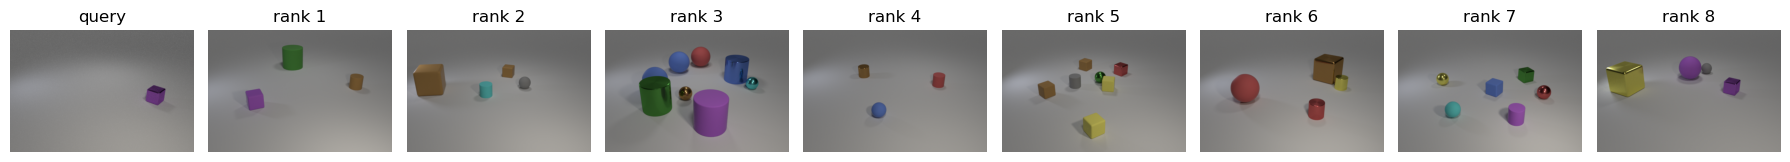

In [ ]:
# Retrieval visualization
import matplotlib.pyplot as plt
from PIL import Image

def load_clevr_image_paths(image_dir, scenes_json, keep_single, max_images=None):
    image_dir = Path(image_dir)
    scenes_json = Path(scenes_json)
    with open(scenes_json, "r", encoding="utf-8") as f:
        data = json.load(f)
    scenes = data.get("scenes", [])
    paths = []
    for scene in scenes:
        objects = scene.get("objects", [])
        is_single = len(objects) == 1
        if keep_single != is_single:
            continue
        filename = scene.get("image_filename")
        if filename is None:
            image_index = scene.get("image_index")
            split = scene.get("split", "val")
            if image_index is None:
                continue
            filename = f"CLEVR_{split}_{image_index:06d}.png"
        path = image_dir / filename
        if path.exists():
            paths.append(path)
        if max_images is not None and len(paths) >= max_images:
            break
    return paths

# Update these paths
DATASET_PATH = "C:/Users/maril/OneDrive/Desktop/GitHub/OADino/oadino/dataset"
SINGLE_IMAGE_DIR = Path(DATASET_PATH + "/single/images_single")
SINGLE_SCENES_JSON = Path(DATASET_PATH + "/single/CLEVR_single_scenes.json")
MULTI_IMAGE_DIR = Path(DATASET_PATH + "/multi/CLEVR_v1.0/images/val")
MULTI_SCENES_JSON = Path(DATASET_PATH + "/multi/CLEVR_v1.0/scenes/CLEVR_val_scenes.json")

single_paths = load_clevr_image_paths(SINGLE_IMAGE_DIR, SINGLE_SCENES_JSON, keep_single=True)
multi_paths = load_clevr_image_paths(MULTI_IMAGE_DIR, MULTI_SCENES_JSON, keep_single=False)

def retrieve_indices(query_idx, topk=8, mode="combo"):
    if mode == "dino":
        q = single_dino
        c = multi_dino
    elif mode == "vae":
        q = single_vae
        c = multi_vae
    else:
        q = single_combo
        c = multi_combo
    sims = F.normalize(q, dim=1) @ F.normalize(c, dim=1).T
    topk = min(topk, c.shape[0])
    return torch.topk(sims[query_idx], k=topk).indices.tolist()

def show_retrieval(query_idx=0, topk=8, mode="combo"):
    idxs = retrieve_indices(query_idx, topk=topk, mode=mode)
    fig, axes = plt.subplots(1, topk + 1, figsize=(2 * (topk + 1), 3))
    # Query image
    q_path = single_paths[query_idx]
    axes[0].imshow(Image.open(q_path))
    axes[0].set_title("query")
    axes[0].axis("off")
    # Retrieved candidates
    for i, j in enumerate(idxs, start=1):
        c_path = multi_paths[j]
        axes[i].imshow(Image.open(c_path))
        axes[i].set_title(f"rank {i}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Example
show_retrieval(query_idx=0, topk=8, mode="combo")